# generate spectrograms of a sequence of wav files

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cognac.insitu as insi

#_flim, _fticks = [1e3,15e3], np.arange(2,16,2)*1e3
_flim, _fticks = [8e3,10e3], np.arange(8,11,.5)*1e3

In [2]:
# open wave file
#sequence_dir = os.getcwd()+'/../data/sequence_mix/' # original mega mix
sequence_dir = os.getcwd()+'/../data/sequence/'

sequence, fs = insi.source.load_emission_sequence(sequence_dir)

## look at one file first

In [3]:
num=0
s = sequence[num]

In [4]:
# play wave file
from IPython.display import Audio
audio = Audio(data=s, rate=s.fs)
audio

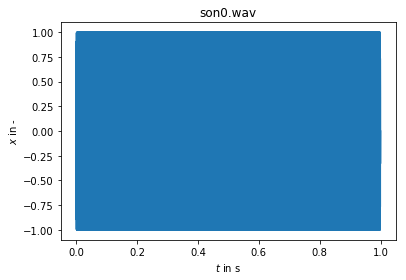

In [5]:
# plot
s.plot(title='son%d.wav'%num)

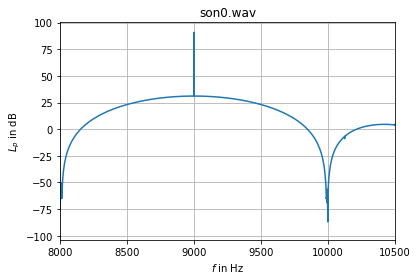

In [6]:
# compute spectrum and plot it
ax = s.plot_power_spectrum(xlim=_flim, title='son%d.wav'%num)
ax.set_xscale('linear')
ax.set_xticks(_fticks)
ax.grid()

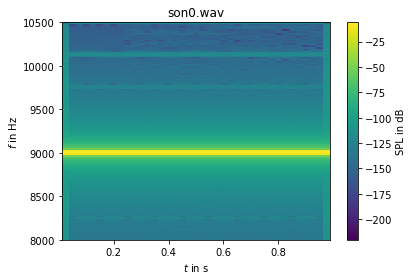

In [7]:
# compute spectrogram and plot it
#ax = s.plot_spectrogram(ylim=_flim, title='son%d.wav'%num)
ax = s.plot_spectrogram(ylim=_flim, NFFT=int(.05*s.fs), noverlap=int(0.025*s.fs),
                        title='son%d.wav'%num)
_ = ax.set_yticks(_fticks)

## process all files

In [8]:
for num, s in enumerate(sequence):

    lab = 'son%0.2d'%num
    #
    fig=plt.figure(figsize=(20,5))
    
    ax = fig.add_subplot(1, 3, 1)
    s.plot(ax=ax, label='son%d.wav'%num)
    #wave.plot(label=lab)
    #thinkplot.config(xlabel='Time (s)')
    ax.set_title('son%d.wav, fs=%.2f kHz'%(num, s.fs/1e3))

    ax = fig.add_subplot(1, 3, 2)
    ax = s.plot_power_spectrum(ax=ax, xlim=_flim, label=str(num))
    ax.set_xscale('linear')
    ax.set_xticks(_fticks)
    ax.grid()

    ax = fig.add_subplot(1, 3, 3)
    s.plot_spectrogram(NFFT=int(.05*s.fs), noverlap=int(0.025*s.fs),
                       ax=ax, ylim=_flim)
    _ = ax.set_yticks(_fticks)
    #ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
    ax.grid()

    # should not be necessary
    plt.close()
    plt.close()
    plt.close()
        
    #print('son%0.2d.png'%num)
    fig.savefig('son%0.2d.png'%num)
    plt.close()

## try to generate files with lower amplitudes

### generate signals

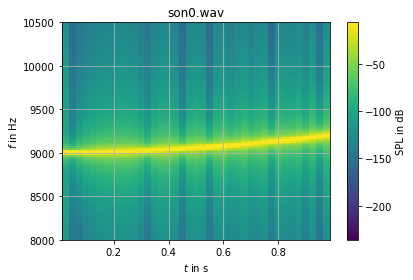

In [8]:
omega = 9e3 # Hz
B = 200 # Hz

def generate_signal(sin, ctype, omega, B, amplitude=1., dt_fade=None):
    s = sin.copy()
    t = np.arange(s.size)/s.fs
    T = t[-1]
    #
    if ctype is 'tone':
        s[:] = np.sin(2*np.pi*omega*t)        
    elif ctype is 'up':
        s[:] = np.sin(2*np.pi*(omega+B/2.*t)*t)
    elif ctype is 'down':
        s[:] = np.sin(2*np.pi*(omega+B-B/2.*t/T)*t)
    elif ctype is 'updown':
        updown = np.maximum(0., np.minimum(1., 2.*t/T))
        updown *= np.maximum(0., np.minimum(1., 2*(T-t)/T))
        phi = (omega+B*updown).cumsum()/s.fs
        s[:] = np.sin(2*np.pi*phi)
    elif ctype is 'nonlinear':
        s[:] = np.sin(2*np.pi*(omega+B/3.*(t/T)**2) *t)
    
    s[:] *= amplitude
    
    if dt_fade:
        fade = np.maximum(0., np.minimum(t/dt_fade, 1.))
        fade *= np.maximum(0., np.minimum((t[-1]-t)/dt_fade, 1.))
        s[:] = s[:]*fade
    #
    return s
    
sc = generate_signal(sequence[0], 'nonlinear', omega, B, dt_fade=1.e-3)

ax = sc.plot_spectrogram(ylim=_flim, NFFT=int(.05*sc.fs), noverlap=int(0.025*sc.fs),
                        title='son%d.wav'%num)
_ = ax.set_yticks(_fticks)
ax.grid()

In [9]:
signals = [{'ctype': 'tone', 'omega': 9e3, 'B': 200},
           {'ctype': 'up', 'omega': 9e3, 'B': 200},
           {'ctype': 'up', 'omega': 9e3, 'B': 400},
           {'ctype': 'up', 'omega': 9e3, 'B': 800},
           {'ctype': 'nonlinear', 'omega': 9e3, 'B': 200},
           {'ctype': 'nonlinear', 'omega': 9e3, 'B': 400},
           {'ctype': 'nonlinear', 'omega': 9e3, 'B': 800},
           {'ctype': 'updown', 'omega': 9e3, 'B': 200},
           {'ctype': 'updown', 'omega': 9e3, 'B': 400},
           {'ctype': 'updown', 'omega': 9e3, 'B': 800},
          ]

for num, sig in enumerate(signals):
    s = generate_signal(sequence[0], sig['ctype'], sig['omega'], sig['B'] , amplitude=.7, dt_fade=1.e-3)
    s.to_wav('son%d.wav'%(num))
    

### play with amplitude

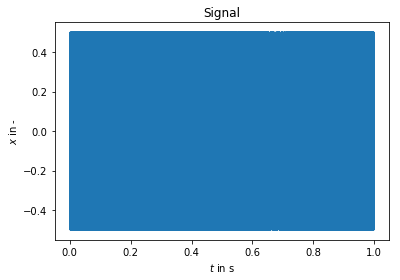

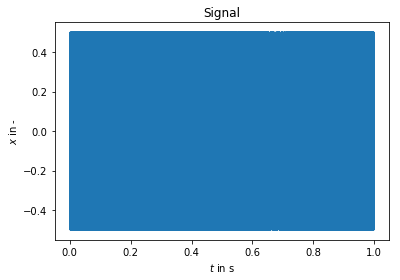

In [21]:
s = sequence[0]
s.normalize().plot()
(s*.5).plot()

In [10]:
amax = 0.7

for num, s in enumerate(sequence):

    lab = 'son%0.2d'%num
    sn = s/s.max()*amax
    s.to_wav('son%d.wav'%(num))